In [1]:
import networkx as nx
import urllib.request
import json
import pandas as pd
import re
import pickle
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Now that we cleaned up the data we can build the network.

In [2]:
data_path = 'data/'
data_path = 'data/'
file = 'links2022.ndjson'

data = pd.read_json(data_path + file, lines=True)
author_posts = dict()
for post in tqdm(range(data.shape[0])):
    # Create a dictionary of authors and their flair, who they answered and their comment
    author_name = data['out_going'][post]
    author_flair = data['flair'][post]
    answered = data['in_going'][post]
    comment = data['comment'][post]
    comment_id = data['id'][post]
    
    # Add author to dictionary or add attributes
    if author_name not in author_posts:
        author_posts[author_name] = [author_flair,[answered],comment,[comment_id]]
    else:
        author_posts[author_name][1].append(answered)
        author_posts[author_name][2] += comment
        author_posts[author_name][3].append(comment_id)

100%|██████████| 1245214/1245214 [00:37<00:00, 33575.65it/s]


### Build Graph

In [3]:
# Create a directed graph
DirectedGraph = nx.MultiDiGraph()
for author_name in author_posts.keys():
    # Add nodes to the graph
    DirectedGraph.add_node(author_name,flair=author_posts[author_name][0],comments=author_posts[author_name][2],comment_id=author_posts[author_name][3])

for author_name in author_posts.keys():
    # Add edges
    for edge_to in author_posts[author_name][1]:
        if edge_to != None:
            DirectedGraph.add_edge(author_name,edge_to)

# Create folder if it does not exist
if not os.path.exists('LargeData'):
    os.makedirs('LargeData')
    
# Save authors as a pickle file
pickle.dump(DirectedGraph, open('LargeData/Directed2022.pkl','wb'))

### Basic Stats

In [4]:
print('Number of nodes: ',DirectedGraph.number_of_nodes())
print('Number of edges: ',DirectedGraph.number_of_edges())

Number of nodes:  40712
Number of edges:  594050


In [5]:
print('Number of multiedges: ',len([x for x in DirectedGraph.edges() if DirectedGraph.number_of_edges(x[0],x[1]) > 1]))

Number of multiedges:  264955


Text(0, 0.5, 'Counts')

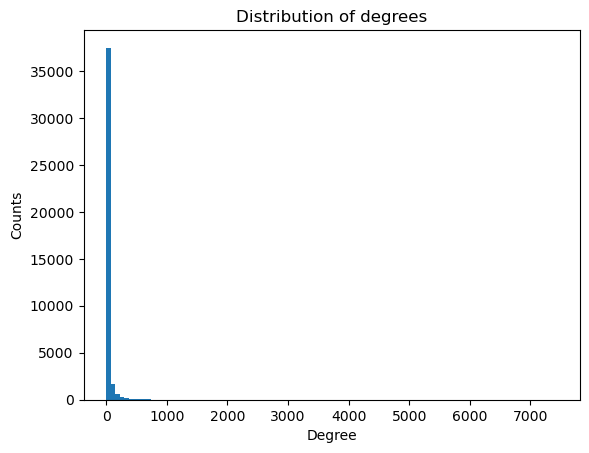

In [6]:
degree_sequence = [d for n, d in DirectedGraph.degree()]
plt.figure()
plt.hist(degree_sequence,bins=100)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')

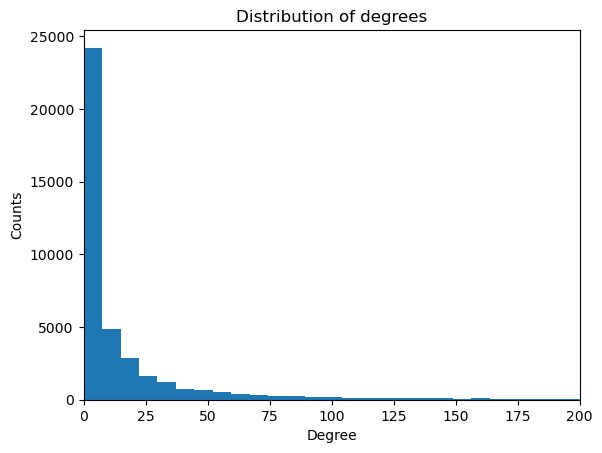

In [7]:
# Plot degree distribution with less tahn 1000 degrees
plt.figure()
plt.hist(degree_sequence,bins=1000)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.xlim(0,200)
plt.show()

In [8]:
# Find node with highest degree
max_degree = 0
max_degree_node = None
for node in DirectedGraph.nodes():
    if DirectedGraph.degree(node) > max_degree:
        max_degree = DirectedGraph.degree(node)
        max_degree_node = node

print('Node with highest degree: ',max_degree_node,' with degree: ',max_degree)

Node with highest degree:  Lastrevio  with degree:  7439


In [9]:
# Print flair of node with highest degree
print('Flair of node with highest degree: ',DirectedGraph.nodes[max_degree_node]['flair'])

Flair of node with highest degree:  intp


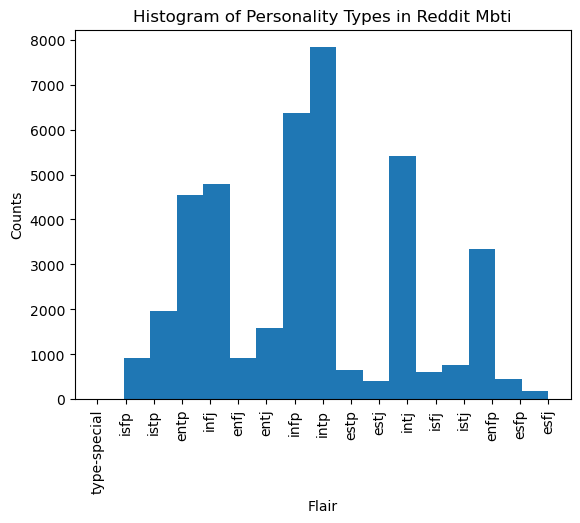

In [10]:
# Distribution of flair
flairs = [DirectedGraph.nodes[node]['flair'] for node in DirectedGraph.nodes()]
plt.figure()
plt.hist(flairs,bins=17)
plt.title('Histogram of Personality Types in Reddit Mbti')
plt.xlabel('Flair')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Make GCC
UndirectedGraph = DirectedGraph.to_undirected()
GCC = nx.subgraph(DirectedGraph,max(nx.weakly_connected_components(DirectedGraph), key=len))


In [12]:
print('number of nodes in GCC: ',len(GCC))
print('number of edges in GCC: ',GCC.number_of_edges())

number of nodes in GCC:  34043
number of edges in GCC:  593969


In [13]:
data.head()

,out_going,in_going,id,flair,comment
0,mbtibot,None,c2arny0,type-special,Done. :)
1,madsweet,None,d3r406m,isfp,I'm an Fi user and I don't think I feel emotio...
2,aNinjaWithAIDS,None,d3r40sv,istp,"I've always thought of Fi as ""*purity of one's..."
3,Poropopper,None,d3r4lcr,entp,"Hahaha, if I were ENTP we would clash, given t..."
4,quiteafewfireflies,None,d3r4wt3,infj,I don't really agree with this. An intuitive w...


In [14]:
pickle.dump(data, open('LargeData/data2022.pkl','wb'))